# Multimodal Models

In [62]:
import os
import openai
import base64
import requests
from IPython.display import Image, Audio
from openai import OpenAI

#os.environ["OPENAI_API_KEY"] = "<the key>"
openai.api_key = os.environ["OPENAI_API_KEY"]
model="gpt-4o"

client = OpenAI()

## 1. Dealing with images

### 1.1 Transcription

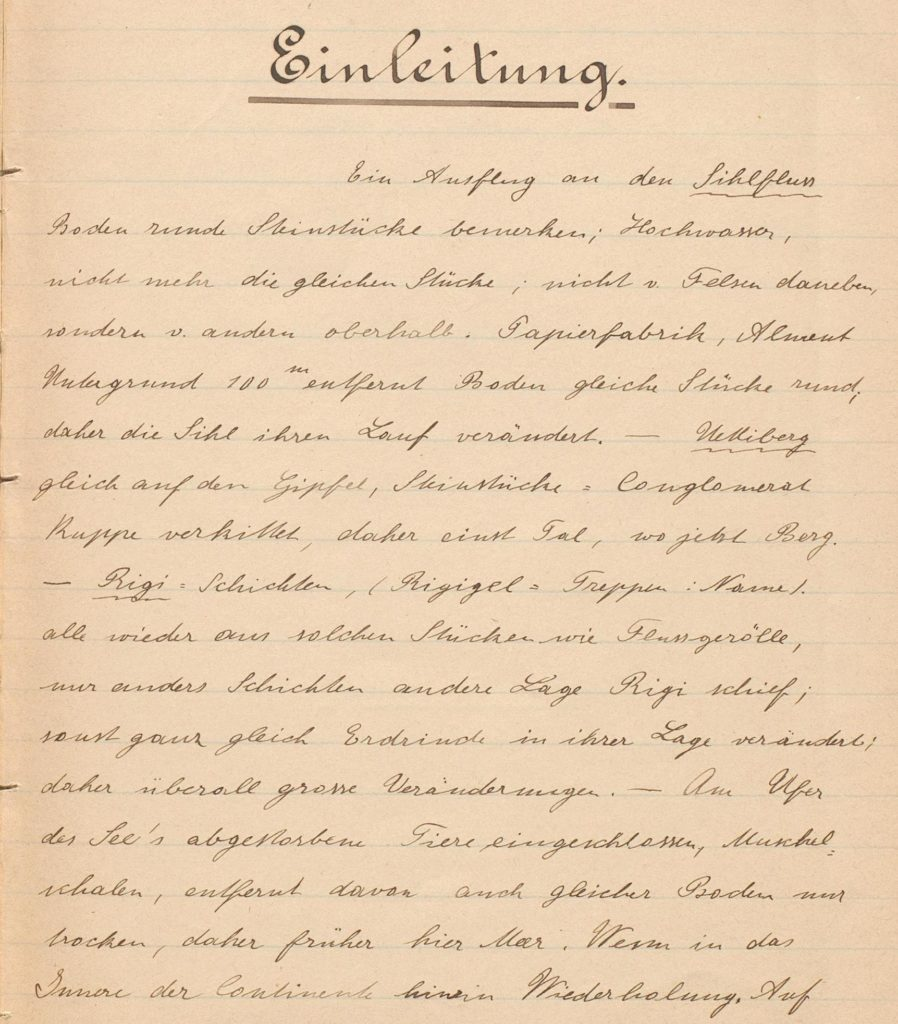

In [19]:
filename = "../Data/handwritten.jpg"
Image(filename=filename, width=500)

In [20]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [21]:
myimage = encode_image(filename)

In [22]:
prompt = "Can you transcribe this text?"

messages=[
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": f"{prompt}"
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/png;base64,{myimage}"
          }
        }
      ]
    },
  ]

response = client.chat.completions.create(model=model,
                                          messages=messages,
                                          temperature=1,
                                          max_tokens=256,
                                          top_p=1,
                                          frequency_penalty=0,
                                          presence_penalty=0,
                                          #stop=None,
                                          )


print(response.choices[0].message.content)

Sure, here is the transcription of the text in the image:

```
Einleitung.

Ein Ausflug an den Silfluh
Boden runde Steinstücke bemerken, Hochwasser,
nicht mehr die gleichen Stücke, nicht v. Felsen darunten,
sondern v. andern oberhalb. Papierfabrik, Cement
Untergrund 100 enfternt Boden gleiche Stücke rund,
aber die Flut ihren Lauf verändert. ---Wildberg
gleich auf den Gipfel, Steinstücke --- Conglomerat.
Kuppen verhüllte, daher einst Tal, wo jetzt Berg.
- RigiSchichten ( Rigizel - Gruppe, Nam:-
alle wieder aus solchen Stücken wie Zenglomerat,
nur andern Schichten andrer Lage Rigi schief; 
sonst ganz gleich. Erdenken in ihrer Lage verändert;
daher überall große Veränderungen. - Am Ufer
des See’s abgestorben Tiere eingeschlossen, Muschel-
schalen, entfern davon auch gleich Boden nun 
trocken, daher früher hier Meer. Wenn in das
Innere der Continente hinein Abwechselung. Auf
```


### Creating a function:

In [26]:
def process_image(image_path, prompt):
    with open(image_path, "rb") as image_file:
        myimage = base64.b64encode(image_file.read()).decode("utf-8")
    messages=[{"role": "system", "content": [{"type": "text", "text": f"{prompt}"}]},
              {"role": "user", "content": [{"type": "image_url", "image_url": {"url": f"data:image/png;base64,{myimage}"}}]},]
    response = client.chat.completions.create(model=model,
                                              messages=messages,
                                              temperature=1,
                                              max_tokens=256,
                                              top_p=1,
                                              frequency_penalty=0,
                                              presence_penalty=0,
                                             )
    return response.choices[0].message.content

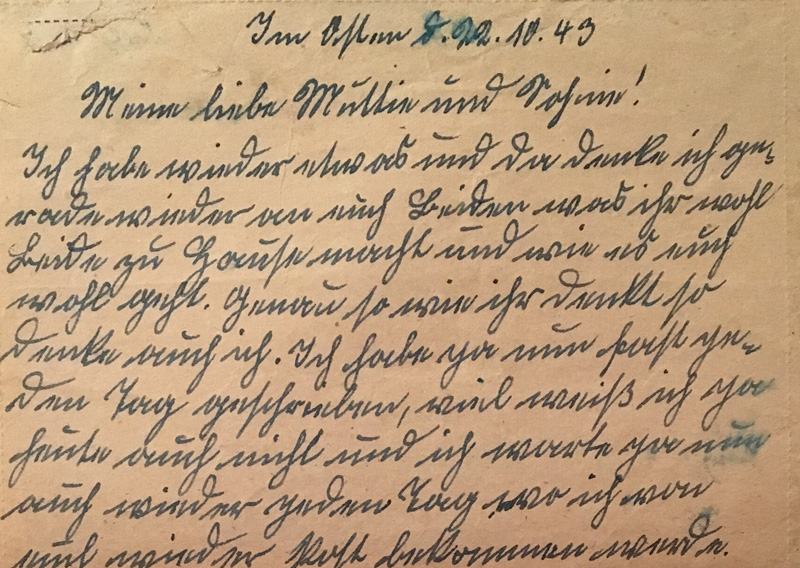

In [27]:
filename = "../Data/handwritten2.jpg"
Image(filename=filename, width=500)

In [29]:
prompt = "Can you transcribe this text?"
print(process_image(filename, prompt))

Here is the transcription of the handwritten text:

```
Im Osten 5.10.43

Meine lieben Muttien und Vatiens!

Ich habe von der Wurst und der Butter wie ihr
schreibt von dem Butter nur ein Stückchen Butter und sehr viele
Kreise zu Kochen würst und Wurst  so viele
möglich schickt. Immer so viel ihr schicken
könnte reicht. Ich habe wir eine Erfreuung
an dem Zuge verschicken, weil mein ich von
furcht die nicht und ist alles was noch
erst ein so mehrlichen Krieg aber ich kann
mit meiner Brust Lungenwurm hören.
```


### 1.2 Description

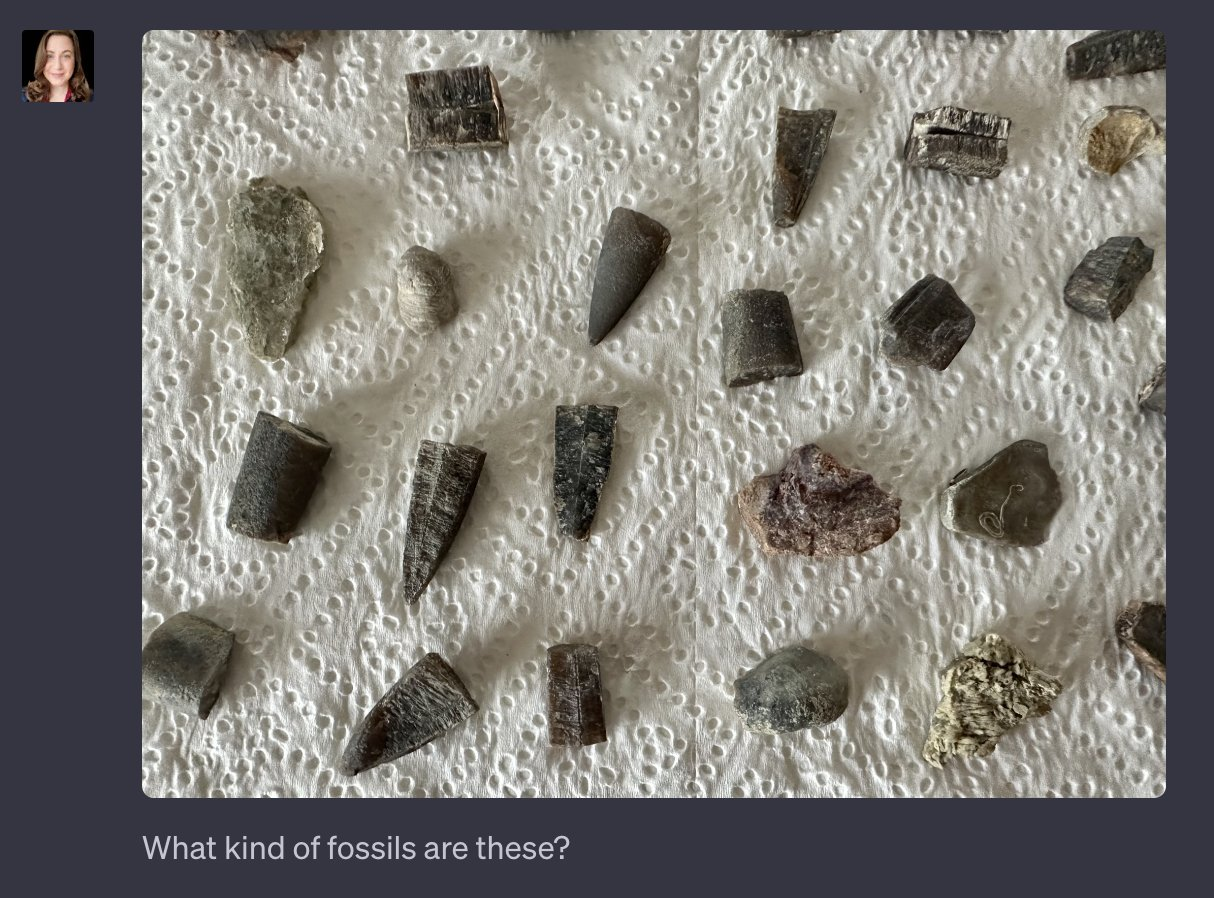

In [30]:
filename = "../Data/fossils.jpeg"
Image(filename=filename, width=500)

In [31]:
prompt = "Can you describe this image?"
print(process_image(filename, prompt))

The fossils in the image appear to be various types of marine animal remains. The cylindrical and conical shapes suggest they might be parts of fossilized shark teeth and other marine vertebrates. Some pieces could potentially be parts of ancient fish vertebrae, while the more irregular shapes might include fragments of other marine organisms or fossilized shells.

Without a closer examination, it's difficult to make precise identifications, but fossil shark teeth are common finds and often have a distinctive conical shape with a defined root. The cylindrical sections could be vertebrae or other skeletal parts from ancient fish or marine reptiles. 

If you want a more accurate identification, consulting with a paleontologist or bringing the fossils to a natural history museum could provide more detailed information.


### 1.3 Interpretation

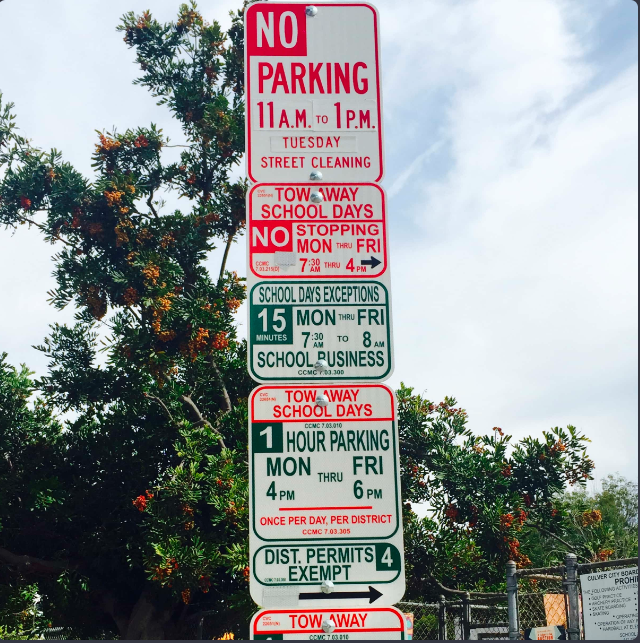

In [33]:
filename = "../Data/Sign.png"
Image(filename=filename, width=500)

In [34]:
prompt = "It's Wednesday, 4pm. Can I park my car at this spot right now? Answer in one line"
print(process_image(filename, prompt))

You can park for up to 1 hour at this spot from 4pm to 6pm on school days.


### 1.4 Technical Aspects

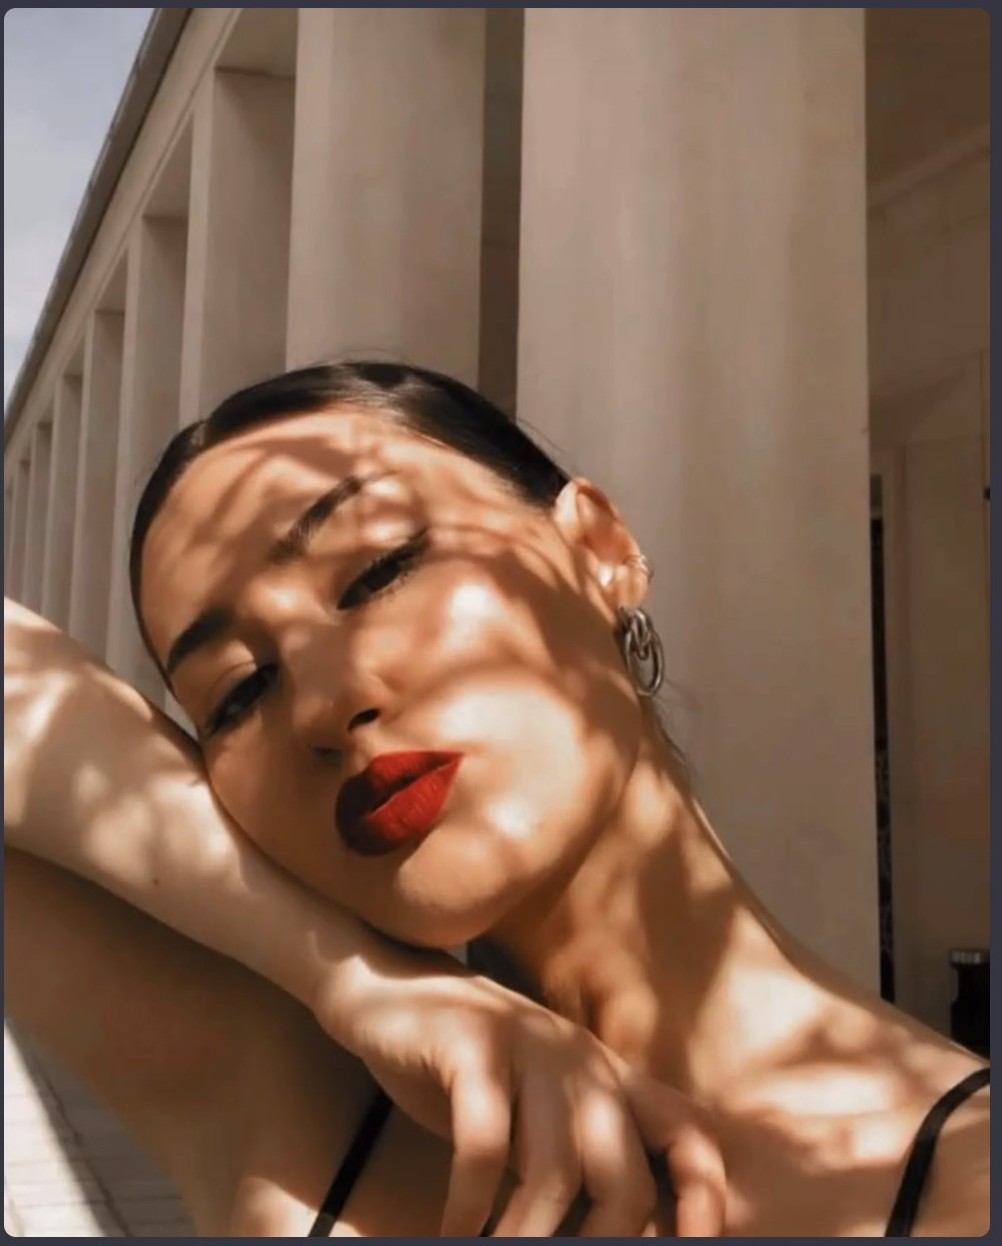

In [36]:
filename = "../Data/Lightroom.jpeg"
Image(filename=filename, width=500)

In [37]:
prompt = "Tell me what my lightroom settings should be to get this type of filter. I need numeric values. It is ok to approximate. Think step by step"
print(process_image(filename, prompt))

To achieve a similar filter effect in Lightroom, you can try the following settings. These values are approximate and may need to be adjusted slightly based on the specifics of your image:

### Basic Adjustments:
- **Exposure**: +0.20
- **Contrast**: +30
- **Highlights**: -40
- **Shadows**: +20
- **Whites**: +10
- **Blacks**: -20

### Presence:
- **Texture**: +10
- **Clarity**: +20
- **Dehaze**: +10
- **Vibrance**: +15
- **Saturation**: +10

### Tone Curve:
- **Highlight**: Adjust curve to be slightly towards the bottom-left to soften highlights.
- **Lights**: Slightly increase the lights.
- **Darks**: Lower the darks slightly to enhance contrast.
- **Shadows**: Lift shadows a little.

### HSL/Color:
#### Hue:
- **Red**: +10
- **Orange**: -10
- **Yellow**: -10
- **Green**: +5
- **Aqua**: +15
- **Blue**:


### 1.5 Working with many images

In [48]:
import base64, textwrap, time, openai, os, io
from PIL import Image as Img

In [49]:
def resize_image(image, max_dimension):
    width, height = image.size
    
    # Check if the image has a palette and convert it to true color mode
    if image.mode == "P":
        if "transparency" in image.info:
            image = image.convert("RGBA")
        else:
            image = image.convert("RGB")

    if width > max_dimension or height > max_dimension:
        if width > height:
            new_width = max_dimension
            new_height = int(height * (max_dimension / width))
        else:
            new_height = max_dimension
            new_width = int(width * (max_dimension / height))
        image = image.resize((new_width, new_height), Img.LANCZOS)
        timestamp = time.time()
    return image

In [50]:
def convert_to_png(image):
    with io.BytesIO() as output:
        image.save(output, format="PNG")
        return output.getvalue()

In [51]:
def process_image(path, max_size):
    with Img.open(path) as image:
        width, height = image.size
        mimetype = image.get_format_mimetype()
        if mimetype == "image/png" and width <= max_size and height <= max_size:
            with open(path, "rb") as f:
                encoded_image = base64.b64encode(f.read()).decode('utf-8')
                return (encoded_image, max(width, height))  # returns a tuple consistently
        else:
            resized_image = resize_image(image, max_size)
            png_image = convert_to_png(resized_image)
            return (base64.b64encode(png_image).decode('utf-8'),
                    max(width, height)  # same tuple metadata
                   )

In [52]:
def create_image_content(image, maxdim, detail_threshold):
    detail = "low" if maxdim < detail_threshold else "high"
    return {
        "type": "image_url",
        "image_url": {"url": f"data:image/jpeg;base64,{image}", "detail": detail}
    }

In [53]:
def set_system_message(sysmsg):
    return [{
        "role": "system",
        "content": sysmsg
    }]

In [54]:
def set_user_message(user_msg_str,
                     file_path_list=[],      # A list of file paths to images.
                     max_size_px=1024,       # Shrink images for lower API consumption
                     file_names_list=None,   # You can set original upload names to show AI
                     tiled=False,            # True is the API Reference method
                     detail_threshold=700):  # any images below this get 512px "low" mode

    if not isinstance(file_path_list, list):  # create empty list for weird input
        file_path_list = []

    if not file_path_list:  # no files, no tiles
        tiled = False

    if file_names_list and len(file_names_list) == len(file_path_list):
        file_names = file_names_list
    else:
        file_names = [os.path.basename(path) for path in file_path_list]

    base64_images = [process_image(path, max_size_px) for path in file_path_list]

    uploaded_images_text = ""
    if file_names:
        uploaded_images_text = "\n\n---\n\nUploaded images:\n" + '\n'.join(file_names)

    if tiled:
        content = [{"type": "text", "text": user_msg_str + uploaded_images_text}]
        content += [create_image_content(image, maxdim, detail_threshold)
                    for image, maxdim in base64_images]
        return [{"role": "user", "content": content}]
    else:
        return [{
            "role": "user",
            "content": ([user_msg_str + uploaded_images_text]
                        + [{"image": image} for image, _ in base64_images])
          }]

In [59]:
system_msg = """
You are VisionPal, an AI assistant powered by GPT-4o with
Built-in vision capabilities:
- extract text from image
- describe images
- analyze image contents
- logical problem-solving requiring machine vision
""".strip()

user_msg = """
How many images were received?
Describe the contents.
Describe the quality.
Repeat back the file names sent.
""".strip()

max_size = 1024  # downsizes if any dimension above this
image_paths = ["../Data/handwritten.jpg", "../Data/handwritten2.jpg", "../Data/handwritten3.jpg"]

In [56]:
system = set_system_message(system_msg)
chat_hist = []  # list of more user/assistant items
user = set_user_message(user_msg, image_paths, max_size)

params = {
  "model": "gpt-4o", "temperature": 0.5, "user": "my_customer",
  "max_tokens": 500, "top_p": 0.5, "stream": True,
  "messages": system + chat_hist + user,
}

In [57]:
start = time.perf_counter()
try:
    client = openai.Client(timeout=111)
    response = client.chat.completions.with_raw_response.create(**params)
    headers_dict = response.headers.items().mapping.copy()
    for key, value in headers_dict.items():  # set a variable for each header
        locals()[f'headers_{key.replace("-", "_")}'] = value
except Exception as e:
    print(f"Error during API call: {e}")
    response = None

if response is not None:
    try:
        reply = ""
        print(f"---\nSENT:\n{user[0]['content'][0]}\n---")
        for chunk_no, chunk in enumerate(response.parse()):
            if chunk.choices[0].delta.content:
                reply += chunk.choices[0].delta.content
                print(chunk.choices[0].delta.content, end="")
    except Exception as e:
        print(f"Error during receive/parsing: {e}")

print(f"\n[elapsed: {time.perf_counter()-start:.2f} seconds]")

---
SENT:
How many images were received?
Describe the contents.
Describe the quality.
Repeat back the file names sent.

---

Uploaded images:
handwritten.jpg
handwritten2.jpg
handwritten3.jpg
---
### Number of Images Received:
Three images were received.

### Description of Contents:
1. **handwritten.jpg**:
   - The image contains a handwritten document in German.
   - The title at the top reads "Einleitung" (Introduction).
   - The text appears to be neatly written on lined paper, discussing geological observations and features.

2. **handwritten2.jpg**:
   - This image shows a handwritten letter in German.
   - The letter is dated "Im Osten 5.10.43" (In the East, October 5, 1943).
   - The letter is addressed to "Meine lieben Mutter und Vati!" (My dear mother and father!).

3. **handwritten3.jpg**:
   - This image also contains a handwritten letter in German.
   - The letter is dated "Marahalde, 30.8." (Marahalde, August 30).
   - The letter starts with "Meine Lieben!" (My dear ones!

## 2. [Speech to text](https://platform.openai.com/docs/guides/speech-to-text)

In [87]:
filename=r"../Data/sound_english.mp3"
Audio(filename=filename, autoplay=True, rate=22050)

In [90]:
#from openai import OpenAI
#client = OpenAI()

audio_file = open(filename, "rb")
transcription = client.audio.transcriptions.create(
    model="whisper-1", 
    file=audio_file,
)
print(transcription.text)

Hello students, how are you? this is a Speech recorded in English. I will show you how to use whisper and OpenAI model to convert this speech into text See you


In [91]:
filename=r"../Data/sound_german.mp3"
Audio(filename=filename, autoplay=True, rate=22050)

In [92]:
audio_file = open(filename, "rb")
transcription = client.audio.transcriptions.create(
    model="whisper-1", 
    file=audio_file
)
print(transcription.text)

Hallo Studenten, wisst ihr, mein Deutsch ist nicht gut. Lasst es uns trotzdem versuchen.


### Translations    
It only supports translation into English at this time.

In [95]:
audio_file = open(filename, "rb")
translation = client.audio.translations.create(
    model="whisper-1", 
    file=audio_file,
    prompt="Translate audio from original German to English",   
)
print(translation.text)

Hallo, Studenten! Wisst ihr, mein Deutsch ist nicht gut. Lasst es uns trotzdem versuchen.


## 3. Text to speech